This notebook runs Random Forest classifier on a feature matrix read in from Pandas dataframe. Use ROC curves to show quality of outcome.

Assuming classes are imbalanced, we use SMOTE to increase the minority class. 

Finally, we re-run the Random Forest classifier on the balanced data set. Use ROC curves to demonstrate the benefit of SMOTE.

In [1]:
!pip install imblearn

In [2]:
!pip install scikit-plot

In [3]:
!jupyter --version

4.4.0


In [4]:
!python --version

Python 3.6.7 :: Anaconda, Inc.


In [5]:
import time
import matplotlib.pyplot as plt
import pandas
print("pandas",pandas.__version__)
import numpy as np
print("numpy",np.__version__)
import sklearn.model_selection
import sklearn.ensemble
import imblearn.over_sampling
import scikitplot.metrics
import random

pandas 0.23.4
numpy 1.13.3


# create fake data

Replace this section with reading in the pkl containing a dataframe of features

alternative to the manual method I use here: use a library to create fake data https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In this notebook I assume the feature matrix has the following characteristics
* no NaNs
* no blanks
* each variable has been normalized
* categorical data has been addressed using an encoding (binary or one-hot or something else)
* classes are balanced

In [6]:
num_rows=10000
ratio_of_classes=0.9

In [7]:
df1 = pandas.DataFrame(np.abs(np.random.randn(num_rows, 4)), columns=list('ABCD'))
df2 = pandas.DataFrame(np.random.randint(10,size=(num_rows, 4)), columns=list('EFGH'))
# https://stackoverflow.com/questions/10803135/weighted-choice-short-and-simple
elements=[0, 1]
weights=[1-ratio_of_classes, ratio_of_classes]
df3 = pandas.DataFrame([np.random.choice(elements, p=weights) for _ in range(num_rows)], columns=['J'])
cleaned_df = pandas.concat([df1, df2,df3], axis=1, join_axes=[df1.index])
cleaned_df.head()

,A,B,C,D,E,F,G,H,J
0,0.130154,1.473826,1.158526,0.958475,6,9,7,0,0
1,0.755470,1.088789,0.168556,0.430410,5,8,2,8,1
2,1.218055,1.435261,3.375614,0.994910,7,1,9,7,0
3,0.504711,0.997916,1.636636,0.453868,2,2,8,1,1
4,0.376424,0.620537,1.133051,1.256041,9,0,8,3,1


# split data


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

In [8]:
X = cleaned_df.drop('J', axis=1)
print('dimensions:',X.shape)
X.head()

dimensions: (10000, 8)


,A,B,C,D,E,F,G,H
0,0.130154,1.473826,1.158526,0.958475,6,9,7,0
1,0.755470,1.088789,0.168556,0.430410,5,8,2,8
2,1.218055,1.435261,3.375614,0.994910,7,1,9,7
3,0.504711,0.997916,1.636636,0.453868,2,2,8,1
4,0.376424,0.620537,1.133051,1.256041,9,0,8,3


In [9]:
y=cleaned_df['J']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

# Random Forest on clean imbalanced data

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [10]:
rf_clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
rf_output = rf_clf.fit(X_train, y_train)
rf_output

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [11]:
rf_clf.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

In [12]:
list_of_importances = list(zip(X.columns,rf_clf.feature_importances_))
output = sorted(list_of_importances, key=lambda x: x[-1],reverse=True)
output

[('C', 0.3417644674023384),
 ('A', 0.16923858295163785),
 ('B', 0.14165668944384691),
 ('D', 0.11221376846013056),
 ('E', 0.088376662275166884),
 ('G', 0.069397265715798323),
 ('H', 0.042327023959510129),
 ('F', 0.035025539791570963)]

Feature ranking:
1. feature 2 (0.341764)
2. feature 0 (0.169239)
3. feature 1 (0.141657)
4. feature 3 (0.112214)
5. feature 4 (0.088377)
6. feature 6 (0.069397)
7. feature 7 (0.042327)
8. feature 5 (0.035026)


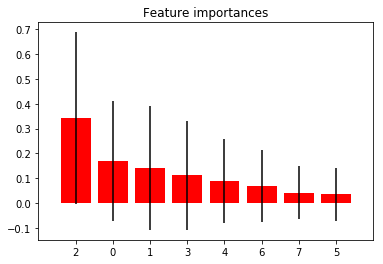

In [13]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

Rather than navigate this code, https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html and https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

I'm going to use <a href="https://github.com/reiinakano/scikit-plot">scikit-plot</a> to visualize the ROC 

In [14]:
# Get y_probabilities
y_probas = rf_clf.predict_proba(X_train) # I'm not clear that X_train is the correct matrix to use here
y_probas[0:10]

array([[ 0.10235531,  0.89764469],
       [ 0.10025461,  0.89974539],
       [ 0.10089712,  0.89910288],
       [ 0.1084525 ,  0.8915475 ],
       [ 0.09951315,  0.90048685],
       [ 0.10225736,  0.89774264],
       [ 0.10215987,  0.89784013],
       [ 0.10163003,  0.89836997],
       [ 0.09929979,  0.90070021],
       [ 0.10188252,  0.89811748]])

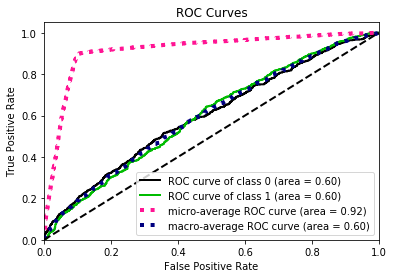

In [15]:
# https://github.com/reiinakano/scikit-plot/blob/master/examples/jupyter_notebooks/plot_roc_curve.ipynb
scikitplot.metrics.plot_roc(y_train, y_probas, cmap='nipy_spectral')
plt.show()

In [16]:
#https://github.com/reiinakano/scikit-plot/blob/master/examples/jupyter_notebooks/plot_confusion_matrix.ipynb
predictions = sklearn.model_selection.cross_val_predict(rf_clf, X_train, y_train,cv=3)
predictions

array([1, 1, 1, ..., 1, 1, 1])

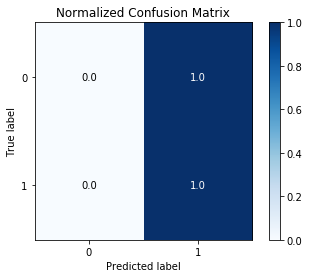

In [17]:
plot = scikitplot.metrics.plot_confusion_matrix(y_train, predictions, normalize=True)

# SMOTE: Synthetic Minority Over-sampling Technique

https://imbalanced-learn.org/en/stable/generated/imblearn.over_sampling.SMOTE.html

https://stackoverflow.com/questions/15065833/imbalance-in-scikit-learn

SMOTE creates synthetic observations of the minority class by:
1. Finding the k-nearest-neighbors for minority class observations (finding similar observations)
1. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.

In [18]:
sm = imblearn.over_sampling.SMOTE(random_state=2)
sm

SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=2, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')

In [19]:
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [20]:
print('X_train',X_train.shape)
print('X_train_res',X_train_res.shape)

X_train (6700, 8)
X_train_res (12020, 8)


In [21]:
print('y_train     ratio:',sum(y_train    ==0),'/',sum(y_train==1),'=',sum(y_train==0)/sum(y_train==1))
print('y_train_res ratio:',sum(y_train_res==0),'/',sum(y_train_res==1),'=',sum(y_train_res==0)/sum(y_train_res==1))

y_train     ratio: 690 / 6010 = 0.11480865224625623
y_train_res ratio: 6010 / 6010 = 1.0


# Re-run Random Forest Classifier using balanced (synthentic) data from SMOTE

In [22]:
rf_clf_balanced = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
rf_output_balanced = rf_clf_balanced.fit(X_train, y_train)
rf_output_balanced

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [23]:
rf_clf_balanced.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1])

Feature ranking:
1. feature 2 (0.341764)
2. feature 0 (0.169239)
3. feature 1 (0.141657)
4. feature 3 (0.112214)
5. feature 4 (0.088377)
6. feature 6 (0.069397)
7. feature 7 (0.042327)
8. feature 5 (0.035026)


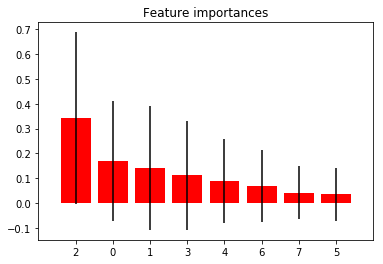

In [24]:
importances = rf_clf_balanced.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf_balanced.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [25]:
# Get y_probabilities
y_probas = rf_clf_balanced.predict_proba(X_train) # I'm not clear that X_train is the correct matrix to use here
y_probas[0:10]

array([[ 0.10235531,  0.89764469],
       [ 0.10025461,  0.89974539],
       [ 0.10089712,  0.89910288],
       [ 0.1084525 ,  0.8915475 ],
       [ 0.09951315,  0.90048685],
       [ 0.10225736,  0.89774264],
       [ 0.10215987,  0.89784013],
       [ 0.10163003,  0.89836997],
       [ 0.09929979,  0.90070021],
       [ 0.10188252,  0.89811748]])

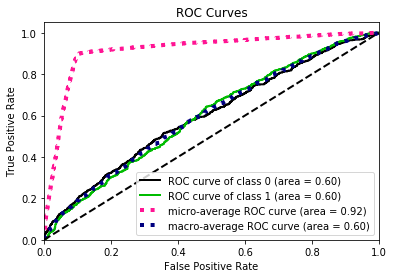

In [26]:
# https://github.com/reiinakano/scikit-plot/blob/master/examples/jupyter_notebooks/plot_roc_curve.ipynb
scikitplot.metrics.plot_roc(y_train, y_probas, cmap='nipy_spectral')
plt.show()

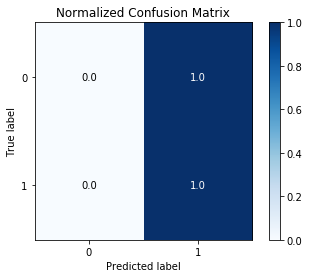

In [27]:
#https://github.com/reiinakano/scikit-plot/blob/master/examples/jupyter_notebooks/plot_confusion_matrix.ipynb
predictions = sklearn.model_selection.cross_val_predict(rf_clf_balanced, X_train, y_train,cv=3)
plot = scikitplot.metrics.plot_confusion_matrix(y_train, predictions, normalize=True)